# Custom predictors for recursive multi-step forecasting

In forecasting time series data, it can be useful to consider additional characteristics beyond just the lagged values. For instance, the moving average of the previous *n* values can help capture the trend in the series.

The `ForecasterAutoregCustom` and `ForecasterAutoregMultiSeriesCustom` classes are similar to `ForecasterAutoreg` and `ForecasterAutoregMultiSeries`, respectively, but they allow the user to define their own function for generating predictors.

To create a custom predictor function, the user needs to write a function that takes a time series as input (a NumPy ndarray) and outputs another NumPy ndarray containing the predictors. The Forecaster parameters used to specify this function are `fun_predictors` and `window_size`.

<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>

<div class="admonition warning" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100;">

<p class="title">
    <i class="fa-triangle-exclamation fa" style="font-size: 18px; color:#ff9100;"></i>
    <b> &nbsp Warning</b>
</p>

The <code>window_size</code> parameter specifies the size of the data window that <code>fun_predictors</code> uses to generate each row of predictors. Choosing the appropriate value for this parameter is crucial to avoid losing data when constructing the training matrices. Be sure to provide the correct value for <code>window_size</code> when using <code>fun_predictors</code>.

</div>

## Libraries

In [1]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiSeriesCustom import ForecasterAutoregMultiSeriesCustom
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## ForecasterAutoregCustom

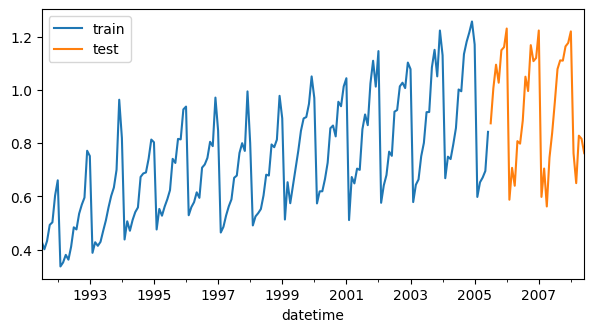

In [2]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y/%m/%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Split train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(7, 3.5))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.legend();

### Custom predictors

In [3]:
# Custom function to create predictors
# ==============================================================================
def create_predictors(y):
    """
    Create first 10 lags of a time series.
    Calculate moving average with window 20.
    """

    lags = y[-1:-11:-1]     # window_size = 10
    mean = np.mean(y[-20:]) # window_size = 20
    predictors = np.hstack([lags, mean])

    return predictors

### Train forecaster

In [4]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                 regressor      = RandomForestRegressor(random_state=123),
                 fun_predictors = create_predictors,
                 name_predictors = [f'lag {i}' for i in range(1, 11)] + ['moving_avg_20'],
                 window_size    = 20 # window_size needed by the mean is the most restrictive one
             )

forecaster.fit(y=data_train)
forecaster

ForecasterAutoregCustom 
Regressor: RandomForestRegressor(random_state=123) 
Predictors created with function: create_predictors 
Transformer for y: None 
Transformer for exog: None 
Window size: 20 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-04-06 20:53:01 
Last fit date: 2023-04-06 20:53:01 
Skforecast version: 0.7.0 
Python version: 3.10.0 

### Prediction

In [5]:
# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps)
predictions.head(3)

2005-07-01    0.926598
2005-08-01    0.948202
2005-09-01    1.020947
Freq: MS, Name: pred, dtype: float64

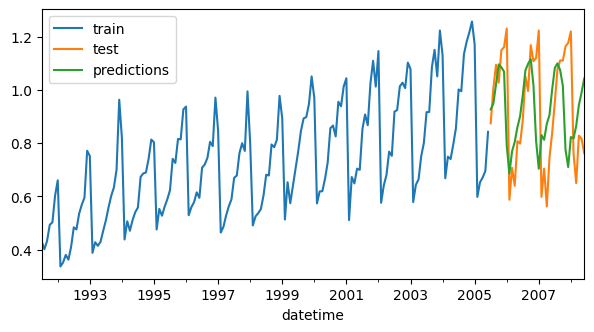

In [6]:
# Plot predictions
# ==============================================================================
fig, ax=plt.subplots(figsize=(7, 3.5))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [7]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test,
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 0.04487765885818191


### Feature importance

In [8]:
forecaster.get_feature_importance()

,feature,importance
0,lag 1,0.539720
1,lag 2,0.119097
2,lag 3,0.046404
3,lag 4,0.024165
4,lag 5,0.030567
5,lag 6,0.015139
6,lag 7,0.042883
7,lag 8,0.012742
8,lag 9,0.018938
9,lag 10,0.108639


### Extract training matrices

In [9]:
X, y = forecaster.create_train_X_y(data_train)
X.head()

,lag 1,lag 2,lag 3,lag 4,lag 5,lag 6,lag 7,lag 8,lag 9,lag 10,moving_avg_20
datetime,,,,,,,,,,,
1993-03-01,0.387554,0.751503,0.771258,0.595223,0.568606,0.534761,0.475463,0.483389,0.410534,0.361801,0.496401
1993-04-01,0.427283,0.387554,0.751503,0.771258,0.595223,0.568606,0.534761,0.475463,0.483389,0.410534,0.496275
1993-05-01,0.413890,0.427283,0.387554,0.751503,0.771258,0.595223,0.568606,0.534761,0.475463,0.483389,0.496924
1993-06-01,0.428859,0.413890,0.427283,0.387554,0.751503,0.771258,0.595223,0.568606,0.534761,0.475463,0.496759
1993-07-01,0.470126,0.428859,0.413890,0.427283,0.387554,0.751503,0.771258,0.595223,0.568606,0.534761,0.495638


In [10]:
y.head()

datetime
1993-03-01    0.427283
1993-04-01    0.413890
1993-05-01    0.428859
1993-06-01    0.470126
1993-07-01    0.509210
Freq: MS, Name: y, dtype: float64

## ForecasterAutoregMultiSeriesCustom

All the methods available for `ForecasterAutoregMultiSeries` can also be applied to ForecasterAutoregMultiSeriesCustom. To learn more about these methods, please refer to the [Multi-series forecasting](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/multi-time-series-forecasting.html) page.

In [11]:
# Data download
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/' +
       'data/simulated_items_sales.csv')
data = pd.read_csv(url, sep=',')

# Data preparation
# ==============================================================================
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('D')
data = data.sort_index()
data.head()

,item_1,item_2,item_3
date,,,
2012-01-01,8.253175,21.047727,19.429739
2012-01-02,22.777826,26.578125,28.009863
2012-01-03,27.549099,31.751042,32.078922
2012-01-04,25.895533,24.567708,27.252276
2012-01-05,21.379238,18.191667,20.357737


In [12]:
# Split data into train-val-test
# ==============================================================================
end_train = '2014-07-15 23:59:00'
data_train = data.loc[:end_train, :].copy()
data_test  = data.loc[end_train:, :].copy()

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates : 2012-01-01 00:00:00 --- 2014-07-15 00:00:00  (n=927)
Test dates  : 2014-07-16 00:00:00 --- 2015-01-01 00:00:00  (n=170)


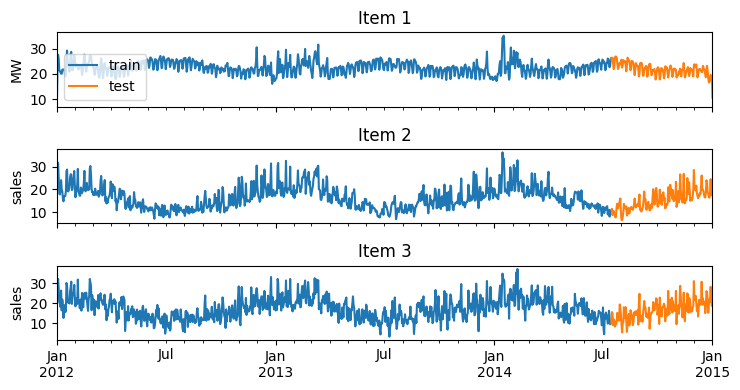

In [13]:
# Plot time series
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7.5, 4), sharex=True)

data_train['item_1'].plot(label='train', ax=axes[0])
data_test['item_1'].plot(label='test', ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('MW')
axes[0].set_title('Item 1')
axes[0].legend()

data_train['item_2'].plot(label='train', ax=axes[1])
data_test['item_2'].plot(label='test', ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('sales')
axes[1].set_title('Item 2')

data_train['item_3'].plot(label='train', ax=axes[2])
data_test['item_3'].plot(label='test', ax=axes[2])
axes[2].set_xlabel('')
axes[2].set_ylabel('sales')
axes[2].set_title('Item 3')

fig.tight_layout()
plt.show();

### Train forecaster

In [14]:
# Custom function to create predictors
# ==============================================================================
def create_complex_predictors(y):
    """
    Create first 10 lags of a time series.
    Calculate moving average with window 20.
    """

    lags = y[-1:-11:-1]     # window_size = 10  
    mean = np.mean(y[-20:]) # window_size = 20
    predictors = np.hstack([lags, mean])

    return predictors

In [15]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregMultiSeriesCustom(
                 regressor       = RandomForestRegressor(random_state=123),
                 fun_predictors  = create_complex_predictors,
                 name_predictors = [f'lag {i}' for i in range(1, 11)] + ['moving_avg_20'],
                 window_size     = 20 # window_size needed by the mean is the most restrictive one
             )

forecaster.fit(series=data_train)
forecaster

ForecasterAutoregMultiSeriesCustom 
Regressor: RandomForestRegressor(random_state=123) 
Predictors created with function: create_complex_predictors 
Transformer for series: None 
Transformer for exog: None 
Window size: 20 
Series levels (names): ['item_1', 'item_2', 'item_3'] 
Series weights: None 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2012-01-01 00:00:00'), Timestamp('2014-07-15 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-04

### Prediction

If no value is specified for the `levels` argument, predictions will be computed for all available levels.

In [16]:
# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, levels=None)
predictions.head(3)

,item_1,item_2,item_3
2014-07-16,25.737550,11.265323,11.328083
2014-07-17,25.649209,10.784593,12.283007
2014-07-18,25.602333,11.273438,12.722012


### Extract training matrices

In [17]:
X_train, y_train, _, _ = forecaster.create_train_X_y(data_train)
X_train.head()

,lag 1,lag 2,lag 3,lag 4,lag 5,lag 6,lag 7,lag 8,lag 9,lag 10,moving_avg_20,item_1,item_2,item_3
0,24.018768,24.772249,29.245869,26.636444,20.228468,18.976196,20.784194,21.758617,21.751748,21.717691,21.954065,1.0,0.0,0.0
1,22.503533,24.018768,24.772249,29.245869,26.636444,20.228468,18.976196,20.784194,21.758617,21.751748,22.666583,1.0,0.0,0.0
2,20.794986,22.503533,24.018768,24.772249,29.245869,26.636444,20.228468,18.976196,20.784194,21.758617,22.567441,1.0,0.0,0.0
3,23.981037,20.794986,22.503533,24.018768,24.772249,29.245869,26.636444,20.228468,18.976196,20.784194,22.389038,1.0,0.0,0.0
4,28.018830,23.981037,20.794986,22.503533,24.018768,24.772249,29.245869,26.636444,20.228468,18.976196,22.495203,1.0,0.0,0.0


In [18]:
y_train.head()

0    22.503533
1    20.794986
2    23.981037
3    28.018830
4    28.747482
Name: y, dtype: float64

In [19]:
%%html
<style>
.jupyter-wrapper .jp-CodeCell .jp-Cell-inputWrapper .jp-InputPrompt {display: none;}
</style>